# 0.Librerías

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler 
import hdbscan
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

# 1. Clustering por producto

In [37]:
df = pd.read_csv(r"C:\Users\alici\Documents\master_data_science\proyecto_nuclio\TFM\datos_arreglados.csv", index_col=0)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

df.head()

,item,category,department,stores,region,week,year,is_holidays,units_sold,sell_price,total_sales
date,,,,,,,,,,,
2013-07-08,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,0,0,12.7414,0.0000
2013-07-15,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,1,0,12.7414,0.0000
2013-07-22,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,29,2013,0,4,10.9858,43.9432
2013-07-29,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,30,2013,0,6,10.9858,65.9148
2013-08-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,31,2013,0,0,10.9858,0.0000


Con las variables que tenemos vamos a obtener el porcentaje de ventas por *quarter* y *region* de cada producto, el precio medio total por producto y la cantidad de unidades vendidas de cada uno.

In [38]:
# Filtramos el DataFrame para obtener solo los datos de la ciudad de Boston
df_boston = df[df['region'] == 'Boston'].copy()

# Creamos una columna 'quarter' a partir del índice 'date'
df_boston['quarter'] = df_boston.index.quarter 

# Calculamos los porcentajes de ventas por ítem para cada cuatrimestre
df_boston = pd.crosstab(df_boston['item'], df_boston['quarter'], values=df_boston['total_sales'], aggfunc='sum', normalize='index')

# Renombramos las columnas de los cuatrimestres
df_boston.columns = ['Boston_Q' + str(col) for col in df_boston.columns]

# El resultado df_boston es un DataFrame con los porcentajes normalizados por ítem y cuatrimestre
df_boston.reset_index(inplace=True)

df_boston

,item,Boston_Q1,Boston_Q2,Boston_Q3,Boston_Q4
0,ACCESORIES_1_001,0.258490,0.215622,0.231207,0.294681
1,ACCESORIES_1_002,0.202792,0.238109,0.254912,0.304187
2,ACCESORIES_1_003,0.254469,0.249112,0.300880,0.195539
3,ACCESORIES_1_004,0.256721,0.259417,0.235593,0.248269
4,ACCESORIES_1_005,0.209317,0.214718,0.267872,0.308094
...,...,...,...,...,...
3044,SUPERMARKET_3_823,0.289806,0.177665,0.216503,0.316026
3045,SUPERMARKET_3_824,0.222281,0.277452,0.319342,0.180925
3046,SUPERMARKET_3_825,0.326950,0.258387,0.230210,0.184453
3047,SUPERMARKET_3_826,0.267774,0.289019,0.237289,0.205918


In [39]:
# Filtramos el DataFrame para obtener ahora los datos de la ciudad de New York
df_ny = df[df['region'] == 'New York'].copy()

# Creamos una columna 'quarter' a partir del índice 'date'
df_ny['quarter'] = df_ny.index.quarter 

# Calculamos los porcentajes de ventas por ítem para cada cuatrimestre
df_ny = pd.crosstab(df_ny['item'], df_ny['quarter'], values=df_ny['total_sales'], aggfunc='sum', normalize='index')

# Renombramos las columnas de los cuatrimestres
df_ny.columns = ['New_York_Q' + str(col) for col in df_ny.columns]

# El resultado df_ny es un DataFrame con los porcentajes normalizados por ítem y cuatrimestre
df_ny.reset_index(inplace=True)

df_ny

,item,New_York_Q1,New_York_Q2,New_York_Q3,New_York_Q4
0,ACCESORIES_1_001,0.290651,0.185303,0.232997,0.291048
1,ACCESORIES_1_002,0.169339,0.190386,0.265158,0.375117
2,ACCESORIES_1_003,0.290550,0.256700,0.191819,0.260931
3,ACCESORIES_1_004,0.265228,0.256632,0.229645,0.248495
4,ACCESORIES_1_005,0.236569,0.200389,0.269576,0.293466
...,...,...,...,...,...
3044,SUPERMARKET_3_823,0.279585,0.208005,0.270410,0.242001
3045,SUPERMARKET_3_824,0.219106,0.344857,0.232286,0.203751
3046,SUPERMARKET_3_825,0.275628,0.230843,0.293817,0.199712
3047,SUPERMARKET_3_826,0.247476,0.296081,0.255348,0.201095


In [40]:
# Filtramos el DataFrame para obtener solo los datos de la ciudad de Philadelphia
df_philadelphia = df[df['region'] == 'Philadelphia'].copy()

# Creamos una columna 'quarter' a partir del índice 'date'
df_philadelphia['quarter'] = df_philadelphia.index.quarter 

# Calculamos los porcentajes de ventas por ítem para cada cuatrimestre
df_philadelphia = pd.crosstab(df_philadelphia['item'], df_philadelphia['quarter'], values=df_philadelphia['total_sales'], aggfunc='sum', normalize='index')

# Renombramos las columnas de los cuatrimestres
df_philadelphia.columns = ['Philadelphia_Q' + str(col) for col in df_philadelphia.columns]

# El resultado df_philadelphia es un DataFrame con los porcentajes normalizados por ítem y cuatrimestre
df_philadelphia.reset_index(inplace=True)

df_philadelphia

,item,Philadelphia_Q1,Philadelphia_Q2,Philadelphia_Q3,Philadelphia_Q4
0,ACCESORIES_1_001,0.280930,0.204212,0.247872,0.266986
1,ACCESORIES_1_002,0.217307,0.173846,0.250679,0.358168
2,ACCESORIES_1_003,0.326288,0.265655,0.222862,0.185195
3,ACCESORIES_1_004,0.286508,0.265151,0.221110,0.227232
4,ACCESORIES_1_005,0.260617,0.192501,0.215559,0.331322
...,...,...,...,...,...
3044,SUPERMARKET_3_823,0.307594,0.198021,0.215576,0.278808
3045,SUPERMARKET_3_824,0.222398,0.321861,0.289589,0.166152
3046,SUPERMARKET_3_825,0.320260,0.251718,0.228474,0.199548
3047,SUPERMARKET_3_826,0.211521,0.293508,0.251753,0.243219


In [41]:
# Hacemos un merge entre df_boston y df_ny
df_merge = pd.merge(df_boston, df_ny, on='item', how='outer')

# Luego, hacemos un merge del resultado anterior con df_philadelphia
df_merge = pd.merge(df_merge, df_philadelphia, on='item', how='outer')

df_merge.head()

,item,Boston_Q1,Boston_Q2,Boston_Q3,Boston_Q4,New_York_Q1,New_York_Q2,New_York_Q3,New_York_Q4,Philadelphia_Q1,Philadelphia_Q2,Philadelphia_Q3,Philadelphia_Q4
0,ACCESORIES_1_001,0.258490,0.215622,0.231207,0.294681,0.290651,0.185303,0.232997,0.291048,0.280930,0.204212,0.247872,0.266986
1,ACCESORIES_1_002,0.202792,0.238109,0.254912,0.304187,0.169339,0.190386,0.265158,0.375117,0.217307,0.173846,0.250679,0.358168
2,ACCESORIES_1_003,0.254469,0.249112,0.300880,0.195539,0.290550,0.256700,0.191819,0.260931,0.326288,0.265655,0.222862,0.185195
3,ACCESORIES_1_004,0.256721,0.259417,0.235593,0.248269,0.265228,0.256632,0.229645,0.248495,0.286508,0.265151,0.221110,0.227232
4,ACCESORIES_1_005,0.209317,0.214718,0.267872,0.308094,0.236569,0.200389,0.269576,0.293466,0.260617,0.192501,0.215559,0.331322


In [42]:
# Calculamos el total de unidades vendidas por 'item'
total_sales_by_item = df.groupby('item')['units_sold'].sum().reset_index(name='total_units_sold')

# Calculamos el precio medio total por 'item'
average_price_by_item = df.groupby('item')['sell_price'].mean().reset_index(name='avg_sell_price')

# Realizamos un merge para agregar las ventas totales por 'item'
df_merge = pd.merge(df_merge, total_sales_by_item, on='item', how='left')

# Realizamos otro merge para agregar el precio medio total por 'item'
df_final_item_region = pd.merge(df_merge, average_price_by_item, on='item', how='left')

df_final_item_region.head()

,item,Boston_Q1,Boston_Q2,Boston_Q3,Boston_Q4,New_York_Q1,New_York_Q2,New_York_Q3,New_York_Q4,Philadelphia_Q1,Philadelphia_Q2,Philadelphia_Q3,Philadelphia_Q4,total_units_sold,avg_sell_price
0,ACCESORIES_1_001,0.258490,0.215622,0.231207,0.294681,0.290651,0.185303,0.232997,0.291048,0.280930,0.204212,0.247872,0.266986,4051,11.039091
1,ACCESORIES_1_002,0.202792,0.238109,0.254912,0.304187,0.169339,0.190386,0.265158,0.375117,0.217307,0.173846,0.250679,0.358168,5047,5.276618
2,ACCESORIES_1_003,0.254469,0.249112,0.300880,0.195539,0.290550,0.256700,0.191819,0.260931,0.326288,0.265655,0.222862,0.185195,1405,3.944072
3,ACCESORIES_1_004,0.256721,0.259417,0.235593,0.248269,0.265228,0.256632,0.229645,0.248495,0.286508,0.265151,0.221110,0.227232,38996,5.981629
4,ACCESORIES_1_005,0.209317,0.214718,0.267872,0.308094,0.236569,0.200389,0.269576,0.293466,0.260617,0.192501,0.215559,0.331322,14529,3.833931


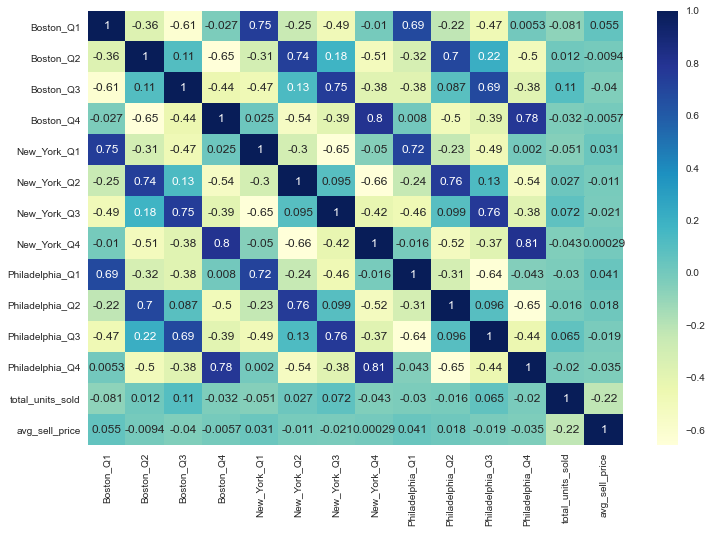

In [43]:
# Obtenemos la correlación de las diferentes variables
plt.figure(figsize=(12, 8))
sns.heatmap(df_final_item_region.corr(), annot=True, cmap="YlGnBu");

In [44]:
df_cluster_product_region= df_final_item_region.copy()

In [45]:
# Guardamos la variable 'ítem'
productos_region = df_cluster_product_region.pop('item')
productos_region

0        ACCESORIES_1_001
1        ACCESORIES_1_002
2        ACCESORIES_1_003
3        ACCESORIES_1_004
4        ACCESORIES_1_005
              ...        
3044    SUPERMARKET_3_823
3045    SUPERMARKET_3_824
3046    SUPERMARKET_3_825
3047    SUPERMARKET_3_826
3048    SUPERMARKET_3_827
Name: item, Length: 3049, dtype: object

In [46]:
# Estandarizamos las variables
ss = StandardScaler()
df_cluster_product_region_ss = pd.DataFrame(
    ss.fit_transform(df_cluster_product_region),
    columns= df_cluster_product_region.columns)

df_cluster_product_region_ss

,Boston_Q1,Boston_Q2,Boston_Q3,Boston_Q4,New_York_Q1,New_York_Q2,New_York_Q3,New_York_Q4,Philadelphia_Q1,Philadelphia_Q2,Philadelphia_Q3,Philadelphia_Q4,total_units_sold,avg_sell_price
0,-0.222054,-0.704803,-0.164482,0.972622,0.558720,-1.354499,-0.276860,0.896965,0.102832,-0.823106,0.200043,0.410154,-0.394344,1.206081
1,-1.279305,-0.268709,0.286179,1.135713,-1.852262,-1.245623,0.347982,2.424325,-1.069016,-1.429579,0.250008,1.943356,-0.371743,-0.063860
2,-0.298388,-0.055345,1.160120,-0.728219,0.556708,0.174859,-1.076884,0.349790,0.938264,0.404003,-0.245146,-0.965125,-0.454387,-0.357528
3,-0.255645,0.144504,-0.081098,0.176399,0.053451,0.173416,-0.341981,0.123847,0.205568,0.393936,-0.276342,-0.258293,0.398622,0.091511
4,-1.155453,-0.722332,0.532581,1.202726,-0.516113,-1.031358,0.433819,0.940884,-0.271296,-1.056991,-0.375139,1.491942,-0.156579,-0.381801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,0.372363,-1.440872,-0.444037,1.338813,0.338780,-0.868220,0.450011,0.005874,0.593960,-0.946756,-0.374840,0.608947,-0.139311,-0.489608
3045,-0.909357,0.494247,1.511108,-0.978943,-0.863191,2.063254,-0.290667,-0.689061,-0.975244,1.526539,0.942617,-1.285335,-0.297586,-0.559770
3046,1.077427,0.124528,-0.183446,-0.918409,0.260145,-0.379010,0.904785,-0.762433,0.827245,0.125655,-0.145255,-0.723783,-0.180723,-0.139359
3047,-0.045831,0.718560,-0.048850,-0.550171,-0.299362,1.018431,0.157392,-0.737304,-1.175588,0.960277,0.269115,0.010515,-0.211221,-0.888269


Probamos con HDBSCAN...

In [47]:
# Inicializamos el algoritmo HDBSCAN 
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=5)
# Ajustamos el modelo y predecimos las etiquetas de clúster
cluster_labels = clusterer.fit_predict(df_cluster_product_region_ss)
# Agregamos las etiquetas del clúster al DataFrame original
df_final_item_region['cluster_hdbscan'] = cluster_labels

df_final_item_region

,item,Boston_Q1,Boston_Q2,Boston_Q3,Boston_Q4,New_York_Q1,New_York_Q2,New_York_Q3,New_York_Q4,Philadelphia_Q1,Philadelphia_Q2,Philadelphia_Q3,Philadelphia_Q4,total_units_sold,avg_sell_price,cluster_hdbscan
0,ACCESORIES_1_001,0.258490,0.215622,0.231207,0.294681,0.290651,0.185303,0.232997,0.291048,0.280930,0.204212,0.247872,0.266986,4051,11.039091,0
1,ACCESORIES_1_002,0.202792,0.238109,0.254912,0.304187,0.169339,0.190386,0.265158,0.375117,0.217307,0.173846,0.250679,0.358168,5047,5.276618,-1
2,ACCESORIES_1_003,0.254469,0.249112,0.300880,0.195539,0.290550,0.256700,0.191819,0.260931,0.326288,0.265655,0.222862,0.185195,1405,3.944072,0
3,ACCESORIES_1_004,0.256721,0.259417,0.235593,0.248269,0.265228,0.256632,0.229645,0.248495,0.286508,0.265151,0.221110,0.227232,38996,5.981629,0
4,ACCESORIES_1_005,0.209317,0.214718,0.267872,0.308094,0.236569,0.200389,0.269576,0.293466,0.260617,0.192501,0.215559,0.331322,14529,3.833931,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,SUPERMARKET_3_823,0.289806,0.177665,0.216503,0.316026,0.279585,0.208005,0.270410,0.242001,0.307594,0.198021,0.215576,0.278808,15290,3.344748,0
3045,SUPERMARKET_3_824,0.222281,0.277452,0.319342,0.180925,0.219106,0.344857,0.232286,0.203751,0.222398,0.321861,0.289589,0.166152,8315,3.026382,0
3046,SUPERMARKET_3_825,0.326950,0.258387,0.230210,0.184453,0.275628,0.230843,0.293817,0.199712,0.320260,0.251718,0.228474,0.199548,13465,4.934034,0
3047,SUPERMARKET_3_826,0.267774,0.289019,0.237289,0.205918,0.247476,0.296081,0.255348,0.201095,0.211521,0.293508,0.251753,0.243219,12121,1.535787,0


In [48]:
df_final_item_region.cluster_hdbscan.value_counts()

 0    2424
-1     620
 1       5
Name: cluster_hdbscan, dtype: int64

Hacemos una segunda iteración con KMeans...

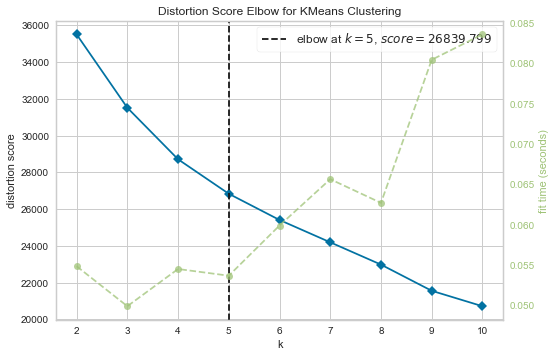

In [49]:
Elbow_M = KElbowVisualizer(KMeans(random_state=42, init="random", n_init="auto"), k=10)
Elbow_M.fit(df_cluster_product_region_ss)
Elbow_M.show();

In [50]:
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
    kmeans.fit(df_cluster_product_region_ss)
    silhouette_scores.append(silhouette_score(df_cluster_product_region_ss, kmeans.labels_))

fig = px.line(
    x=range(2, 10),
    y=silhouette_scores,
    title="Silhouette score",
    labels={"x": "k", "y": "Silhouette score"},
)
fig.show()

In [51]:
kmeans= KMeans(n_clusters=3,random_state=42, init="random", n_init="auto")
kmeans.fit(df_cluster_product_region_ss)
df_final_item_region["cluster_kmeans"] = kmeans.labels_

c:\Users\alici\anaconda3\envs\Nuclio_env\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



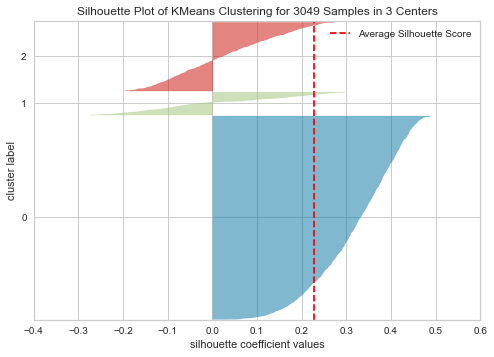

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3049 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [52]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df_cluster_product_region_ss)  
visualizer.show()

In [53]:
df_final_item_region.head()

,item,Boston_Q1,Boston_Q2,Boston_Q3,Boston_Q4,New_York_Q1,New_York_Q2,New_York_Q3,New_York_Q4,Philadelphia_Q1,Philadelphia_Q2,Philadelphia_Q3,Philadelphia_Q4,total_units_sold,avg_sell_price,cluster_hdbscan,cluster_kmeans
0,ACCESORIES_1_001,0.258490,0.215622,0.231207,0.294681,0.290651,0.185303,0.232997,0.291048,0.280930,0.204212,0.247872,0.266986,4051,11.039091,0,2
1,ACCESORIES_1_002,0.202792,0.238109,0.254912,0.304187,0.169339,0.190386,0.265158,0.375117,0.217307,0.173846,0.250679,0.358168,5047,5.276618,-1,0
2,ACCESORIES_1_003,0.254469,0.249112,0.300880,0.195539,0.290550,0.256700,0.191819,0.260931,0.326288,0.265655,0.222862,0.185195,1405,3.944072,0,0
3,ACCESORIES_1_004,0.256721,0.259417,0.235593,0.248269,0.265228,0.256632,0.229645,0.248495,0.286508,0.265151,0.221110,0.227232,38996,5.981629,0,0
4,ACCESORIES_1_005,0.209317,0.214718,0.267872,0.308094,0.236569,0.200389,0.269576,0.293466,0.260617,0.192501,0.215559,0.331322,14529,3.833931,0,0


Una vez analizados los datos obtenidos, decidimos optar mejor por el porcentaje de ventas totales por *quarter* de cada producto, el precio medio total por producto y la cantidad de unidades vendidas de cada uno, ya que nos parecen variables más representativas.

In [54]:
# Creamos un diccionario para mapear los nombres de las columnas
quarter_names = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'}

# Creamos una columna 'quarter' a partir del índice 'date' y aplicamos el mapeo
df['quarter'] = (df.index.month - 1) // 3 + 1
df['quarter'] = df['quarter'].map(quarter_names)

# Calculamos los porcentajes de ventas por ítem y cuatrimestre
df_perc_quarter_item = pd.crosstab(df['item'], df['quarter'], values=df['total_sales'], aggfunc='sum', normalize='index')

# Calculamos las unidades totales vendidas por ítem
units_total = df.groupby('item')['units_sold'].sum()

# Calculamos el precio medio por ítem
avg_price = df.groupby('item').apply(lambda x: (x['total_sales'].sum() / x['units_sold'].sum()))

# Convertimos las Series en DataFrames para unirlos más fácilmente después
units_total_by_item_df = units_total.reset_index(name='units_total')
average_price_by_item_df = avg_price.reset_index(name='avg_price')

# Unimos los DataFrames para tener todos los datos juntos
df_final = df_perc_quarter_item.reset_index()  
df_final = df_final.merge(units_total_by_item_df, on='item')
df_final = df_final.merge(average_price_by_item_df, on='item')

df_final.head()

,item,Q1,Q2,Q3,Q4,units_total,avg_price
0,ACCESORIES_1_001,0.281263,0.195372,0.234402,0.288963,4051,11.000712
1,ACCESORIES_1_002,0.199654,0.190240,0.255982,0.354124,5047,5.279317
2,ACCESORIES_1_003,0.289062,0.256714,0.227942,0.226282,1405,3.938599
3,ACCESORIES_1_004,0.266751,0.258757,0.229655,0.244836,38996,6.006287
4,ACCESORIES_1_005,0.234197,0.202624,0.257898,0.305281,14529,3.807422


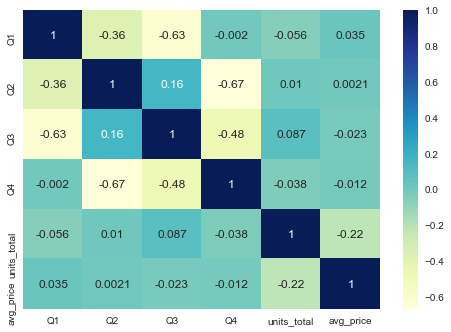

In [55]:
# Obtenemos la correlación de las diferentes variables
sns.heatmap(df_final.corr(), annot=True, cmap="YlGnBu");

Ya que ninguna variable tiene una alta correlación entre sí, no vamos a proceder a eliminar ninguna.

In [56]:
df_cluster_product= df_final.copy()

In [57]:
# Guardamos la variable 'ítem'
productos = df_cluster_product.pop('item')
productos

0        ACCESORIES_1_001
1        ACCESORIES_1_002
2        ACCESORIES_1_003
3        ACCESORIES_1_004
4        ACCESORIES_1_005
              ...        
3044    SUPERMARKET_3_823
3045    SUPERMARKET_3_824
3046    SUPERMARKET_3_825
3047    SUPERMARKET_3_826
3048    SUPERMARKET_3_827
Name: item, Length: 3049, dtype: object

In [58]:
# Cambiamos todos los nombres de las columnas a strings
df_cluster_product.columns = df_cluster_product.columns.astype(str)
# Estandarizamos las características
ss = StandardScaler()
df_cluster_product_ss = pd.DataFrame(
    ss.fit_transform(df_cluster_product),
    columns= df_cluster_product.columns)

df_cluster_product_ss

,Q1,Q2,Q3,Q4,units_total,avg_price
0,0.294480,-1.202115,-0.168496,0.907702,-0.394344,1.203613
1,-1.474984,-1.317252,0.285475,2.139800,-0.371743,-0.060003
2,0.463571,0.174213,-0.304391,-0.277493,-0.454387,-0.356112
3,-0.020167,0.220060,-0.268369,0.073347,0.398622,0.100554
4,-0.726012,-1.039404,0.325791,1.216253,-0.156579,-0.385083
...,...,...,...,...,...,...
3044,0.402209,-1.059728,0.210600,0.353026,-0.139311,-0.495808
3045,-1.021481,1.728044,0.451166,-0.970990,-0.297586,-0.551936
3046,0.737654,-0.110570,0.345690,-0.860815,-0.180723,-0.151334
3047,-0.540336,1.002684,0.157753,-0.515575,-0.211221,-0.886764


Probamos con HDBSCAN...

In [59]:
# Inicializamos el algoritmo HDBSCAN 
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=5)
# Ajustamos el modelo y predecimos las etiquetas de clúster
cluster_labels = clusterer.fit_predict(df_cluster_product_ss)

pd.Series(cluster_labels).value_counts()

 1    2307
-1     737
 0       5
dtype: int64

Los clusters obtenidos no nos aportan mucha información ya que más del 20% de los datos los califica como ruido, y engloba más del 90% restante en un solo grupo.
Decidimos por ello probar una segunda iteración con Kmeans...

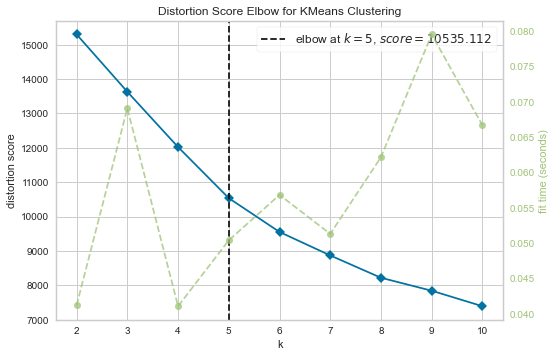

In [60]:
Elbow_M = KElbowVisualizer(KMeans(random_state=42, init="random", n_init="auto"), k=10)
Elbow_M.fit(df_cluster_product_ss)
Elbow_M.show();

In [61]:
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
    kmeans.fit(df_cluster_product_ss)
    silhouette_scores.append(silhouette_score(df_cluster_product_ss, kmeans.labels_))

fig = px.line(
    x=range(2, 10),
    y=silhouette_scores,
    title="Silhouette score",
    labels={"x": "k", "y": "Silhouette score"},
)
fig.show()

In [62]:
kmeans= KMeans(n_clusters=5,random_state=42, init="random", n_init="auto")
kmeans.fit(df_cluster_product_ss)
df_final["cluster_kmeans"] = kmeans.labels_

c:\Users\alici\anaconda3\envs\Nuclio_env\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



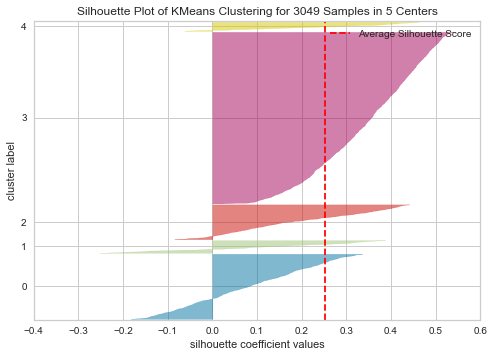

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3049 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [63]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df_cluster_product_ss)  
visualizer.show()

In [64]:
df_final.head()

,item,Q1,Q2,Q3,Q4,units_total,avg_price,cluster_kmeans
0,ACCESORIES_1_001,0.281263,0.195372,0.234402,0.288963,4051,11.000712,2
1,ACCESORIES_1_002,0.199654,0.190240,0.255982,0.354124,5047,5.279317,3
2,ACCESORIES_1_003,0.289062,0.256714,0.227942,0.226282,1405,3.938599,3
3,ACCESORIES_1_004,0.266751,0.258757,0.229655,0.244836,38996,6.006287,3
4,ACCESORIES_1_005,0.234197,0.202624,0.257898,0.305281,14529,3.807422,3


In [65]:
# Calculamos los centroides 
df_centroides= pd.DataFrame(kmeans.cluster_centers_,columns=kmeans.feature_names_in_)
df_centroides['Centroide'] = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
df_centroides.set_index('Centroide', inplace=True)

df_centroides

,Q1,Q2,Q3,Q4,units_total,avg_price
Centroide,,,,,,
Cluster 1,0.849733,-0.676020,-1.043919,0.766960,-0.197905,-0.179532
Cluster 2,-1.558912,2.365782,1.800787,-2.252805,-0.171767,0.121676
Cluster 3,0.076144,-0.027137,-0.018194,-0.027181,-0.301642,2.058300
Cluster 4,-0.208445,0.084962,0.241595,-0.106969,-0.064653,-0.314259
Cluster 5,-0.267998,0.038667,0.474571,-0.225421,4.055215,-0.840264


In [66]:
# Desestandarizamos las variables
df_centroides= pd.DataFrame(
    ss.inverse_transform(df_centroides),
    columns= df_cluster_product.columns)

df_centroides

,Q1,Q2,Q3,Q4,units_total,avg_price
0,0.306872,0.218820,0.192789,0.281519,12707.805022,4.738117
1,0.195783,0.354391,0.328012,0.121814,13859.666667,6.101925
2,0.271193,0.247740,0.241547,0.239520,8136.273481,14.870561
3,0.258068,0.252736,0.253896,0.235300,18580.071188,4.128101
4,0.255321,0.250673,0.264970,0.229036,200137.372340,1.746458


Vamos a proceder a visualizar los centroides comparando todas las variables de *df_cluster_product_ss.* *Q1* y *Q2* por un lado, *Q3* y *Q4* por otro, y *units_total* con *avg_price* en una última gráfica.

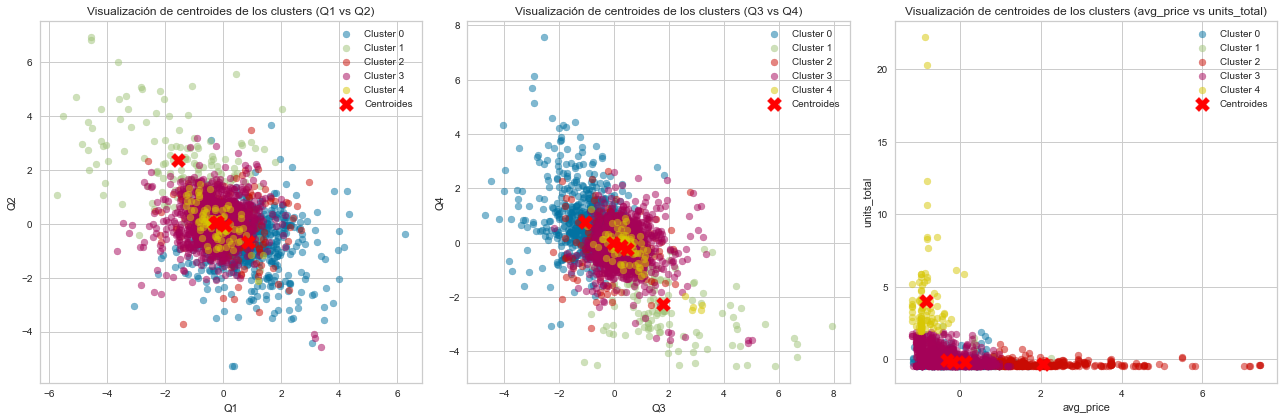

In [72]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Definimos los títulos y las columnas para cada subplot
titles = ['Q1 vs Q2', 'Q3 vs Q4', 'avg_price vs units_total']
columns = [(0, 1), (2, 3), (5, 4)]

for i, ax in enumerate(axs):
    # Graficamos los puntos de datos
    for j in range(kmeans.n_clusters):
        ax.scatter(
            df_cluster_product_ss.iloc[labels == j, columns[i][0]],
            df_cluster_product_ss.iloc[labels == j, columns[i][1]],
            label=f'Cluster {j}',
            cmap='viridis',
            marker='o',
            alpha=0.5
        )

    # Graficamos los centroides
    ax.scatter(
        centroids[:, columns[i][0]],
        centroids[:, columns[i][1]],
        c='red',
        marker='X',
        s=200,
        label='Centroides'
    )

    ax.set_title(f'Visualización de centroides de los clusters ({titles[i]})')
    ax.set_xlabel(df_cluster_product_ss.columns[columns[i][0]])
    ax.set_ylabel(df_cluster_product_ss.columns[columns[i][1]])

    ax.legend()

plt.tight_layout()
plt.show()


Vamos a analizar los clusters mediante boxplots para sacar mejores conclusiones de cada uno de ellos.

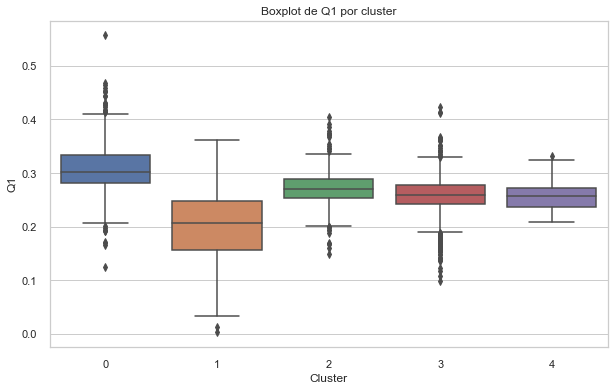

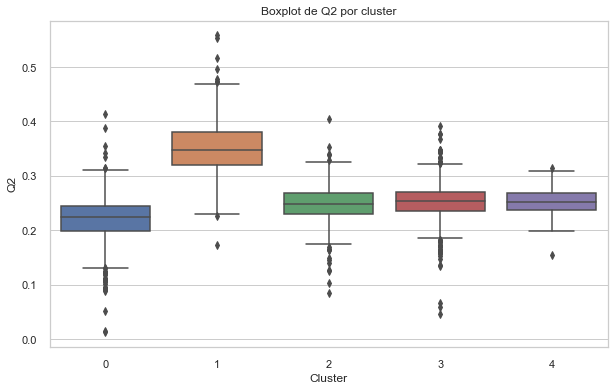

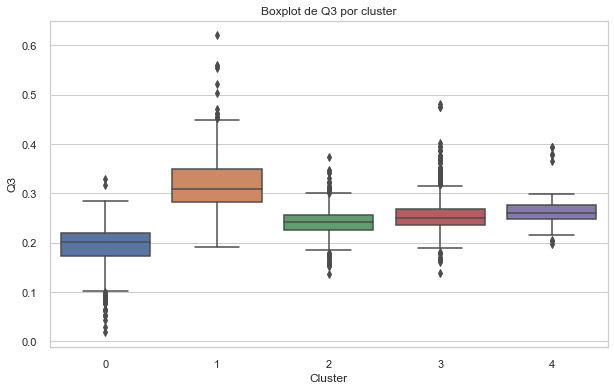

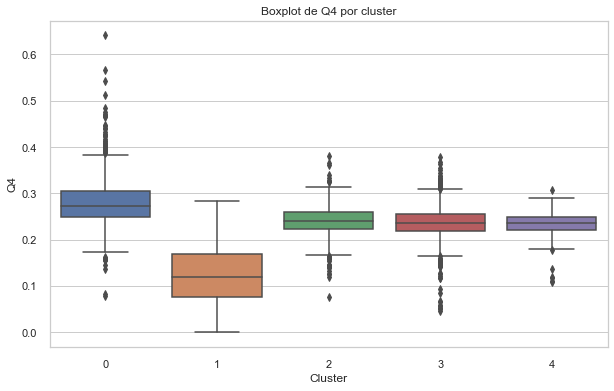

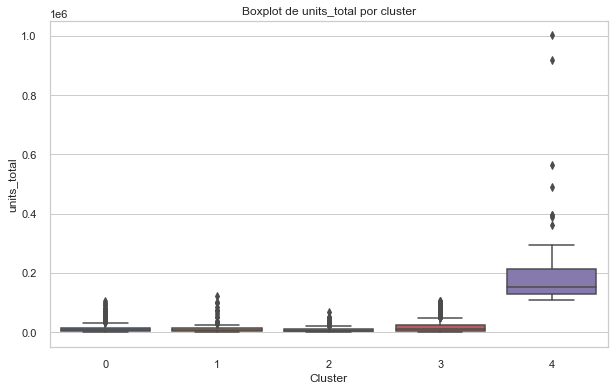

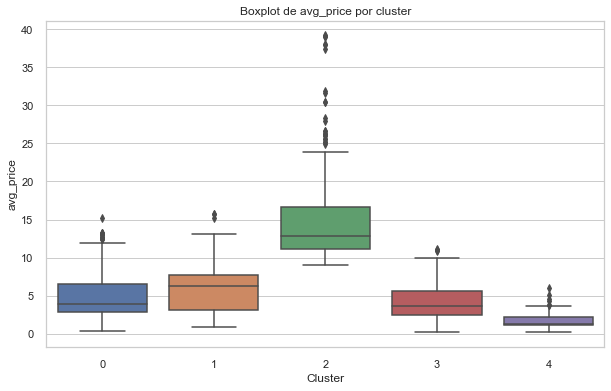

In [76]:
# Establecemos el estilo de los gráficos
sns.set(style="whitegrid")

# Creamos un boxplot para cada variable en función del cluster
for variable in ['Q1', 'Q2', 'Q3', 'Q4', 'units_total', 'avg_price']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster_kmeans', y=variable, data=df_final)
    plt.title(f'Boxplot de {variable} por cluster')
    plt.xlabel('Cluster')
    plt.ylabel(variable)
    plt.show()


In [70]:
df_final.to_csv("clusteringproducto.csv")